In [2]:
import numpy as np
import pandas as pd
#import pydub
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
import datetime
import os
import sklearn
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = "retina"

https://github.com/tyiannak/pyAudioAnalysis

## initial attempt

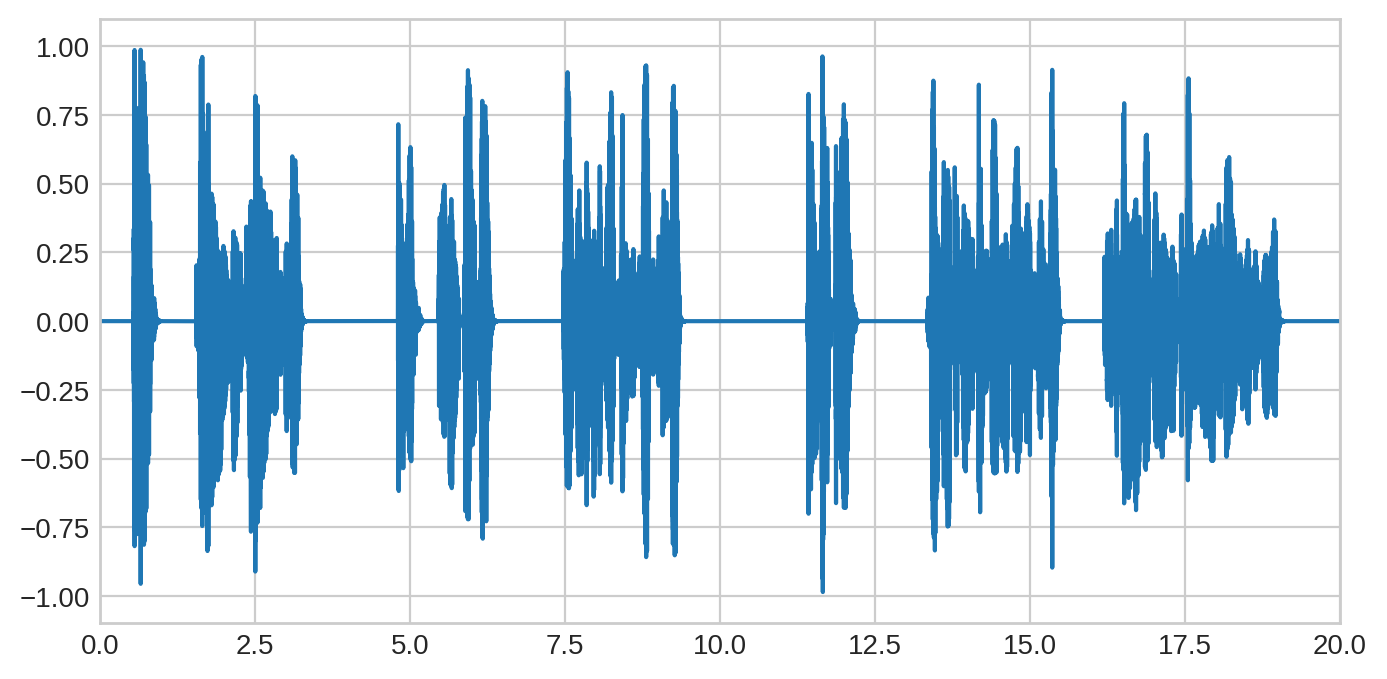

In [6]:
# def read(f, normalized=False):
#     """MP3 to numpy array"""
#     a = pydub.AudioSegment.from_mp3(f)
#     y = np.array(a.get_array_of_samples())
#     if a.channels == 2:
#         y = y.reshape((-1, 2))
#     if normalized:
#         return a.frame_rate, np.float32(y) / 2**15
#     else:
#         return a.frame_rate, y
    
# load audio
filename = './data/Track 2.wav'
data, fs = sf.read(filename, dtype='float32')
# fs, data = read(filename)
time = np.linspace(0, len(data) / fs, num=len(data))

# creat channel name
prefix = 'channel_'
n_channels = data.shape[1]
n_str = np.arange(1, n_channels + 1, 1, dtype=str)
channels = [prefix + i for i in n_str]

# convert to pandas df
pd_data = pd.DataFrame(data, columns=channels)
pd_data['seconds'] = time

# visulise signal 
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(pd_data['seconds'], pd_data['channel_1'])

ax.set_xlim([0, 20])
plt.rc("figure", dpi=100)
plt.style.use("seaborn-whitegrid")
plt.show()

## inaSpeechSegmenter

### Audio Segmentation
https://github.com/ina-foss/inaSpeechSegmenter

### Speech to Text
https://cloud.ibm.com/apidocs/speech-to-text/speech-to-text?code=python

### Proofreading
https://www.bitblokes.de/languagetool-3-4-ist-veroeffentlicht-korrekturlesen-mit-open-source/

In [8]:
# Load the API (Current warning is related to h5py and has no consequences)
from inaSpeechSegmenter import Segmenter, seg2csv
seg = Segmenter()

Using TensorFlow backend.


In [10]:
segments = seg(filename)
pd_segments = pd.DataFrame(segments).rename(columns={0:'Class', 1:'Start', 2:'Stop'})

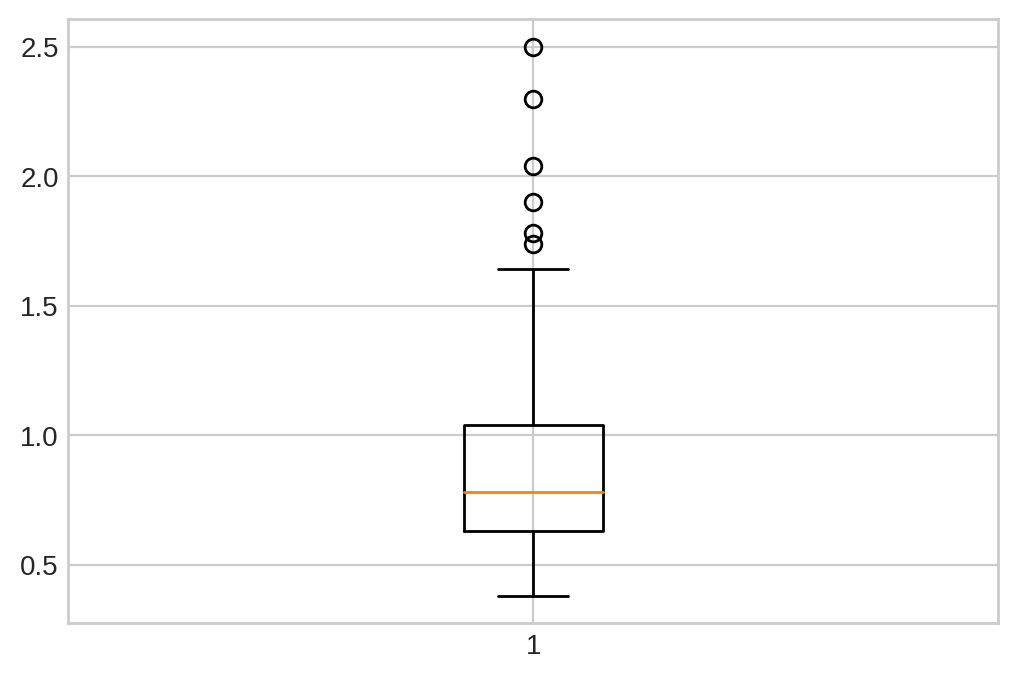

In [11]:
pd_segments['interval'] = pd_segments['Stop'] - pd_segments['Start']
plt.boxplot(pd_segments[pd_segments.Class=='noEnergy']['interval'])
plt.show()

In [12]:
pd_segments

,Class,Start,Stop,interval
0,noEnergy,0.00,0.52,0.52
1,female,0.52,0.88,0.36
2,noEnergy,0.88,1.54,0.66
3,male,1.54,3.26,1.72
4,noEnergy,3.26,4.78,1.52
...,...,...,...,...
104,noEnergy,147.52,148.26,0.74
105,female,148.26,150.12,1.86
106,noEnergy,150.12,150.86,0.74
107,female,150.86,151.82,0.96


In [22]:
Q3 = np.quantile(pd_segments[pd_segments.Class=='noEnergy']['interval'].values, 0.75)
Q3

1.0399999999999991

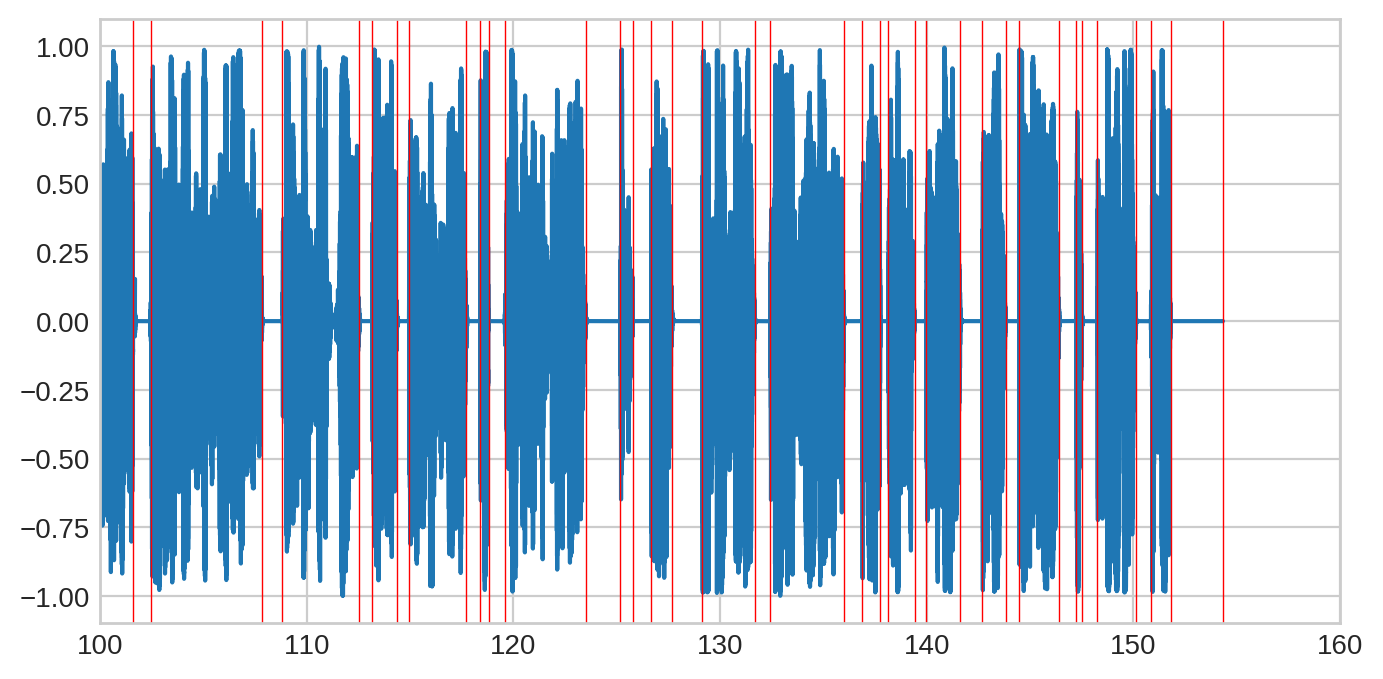

In [17]:
# visulise signal 
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(pd_data['seconds'], pd_data['channel_1'])
pd_pause = pd_segments[pd_segments.Class == 'noEnergy']
for i in range(len(pd_pause)):
    ax.axvline(x=pd_pause.iloc[i]['Start'], color='red', lw=0.5)
    ax.axvline(x=pd_pause.iloc[i]['Stop'], color='red', lw=0.5)

ax.set_xlim([100, 160])
plt.rc("figure", dpi=100)
plt.style.use("seaborn-whitegrid")
plt.show()

In [23]:
index = []

for i in range(len(pd_segments)):
    if pd_segments.iloc[i].Class == 'noEnergy':
        pause = pd_segments.iloc[i].interval
        if pause >= Q3:
            index.append(i)

seg = [(str(datetime.timedelta(seconds=0)), 
        str(datetime.timedelta(seconds=pd_segments.iloc[index[0]].Start)).split('.')[0])]

for i in range(1, len(index)):
    left = str(datetime.timedelta(seconds=pd_segments.iloc[index[i-1]].Start)).split('.')[0]
    right = str(datetime.timedelta(seconds=pd_segments.iloc[index[i]].Start)).split('.')[0]
    sentence = (left, right)
    seg.append(sentence)

seg

[('0:00:00', '0:00:03'),
 ('0:00:03', '0:00:06'),
 ('0:00:06', '0:00:09'),
 ('0:00:09', '0:00:12'),
 ('0:00:12', '0:00:24'),
 ('0:00:24', '0:00:32'),
 ('0:00:32', '0:00:51'),
 ('0:00:51', '0:01:10'),
 ('0:01:10', '0:01:28'),
 ('0:01:28', '0:01:37'),
 ('0:01:37', '0:02:03'),
 ('0:02:03', '0:02:07'),
 ('0:02:07', '0:02:21'),
 ('0:02:21', '0:02:31')]

In [43]:
pd_segments[~(pd_segments.Class =='noEnergy')].iloc[0]
# apt-get install ffmpeg libavcodec-extra

Class       female
Start         0.52
Stop          0.88
interval      0.36
Name: 1, dtype: object